# Ethical Implication of Deepfake Technology in Facial Recognition System

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = '140k-real-and-fake-faces:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F501529%2F939937%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240501%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240501T063051Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D43ce2dbe7988d41cca7890dc68e49cf2ff9b9e473c5366e141360020220b8f1c7781576f09e6e32a47b0a1271eac573819444ee3111907abd6b51eb8d249466730b449ba72fa4b7d7a3c2b85a61113f6ceb38fdf7b122a739c66173f3bfef1f92e66cff9a1d3207a96bde7e17a012d2ac9192d301aa871327704aab8f82d0ed29ab64a6e1bd97754328ee2f568bbb45d84bb90afea4338cdf14e29a2c4008e47b82c99e57e3c82c2018740dfe8b8ded61a32a2fe23e9565184192174836099c33fe8b14f8cf7cc795b36d9a7184d617bea5ccf6fba172c6e7450800afe95b6fa2f0dc7178454a1ce680e0c713f7d46a74cd4d13b609649f5e86c7fa9cfa6dbb4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 4024555718 bytes downloaded
Downloaded and uncompressed: 140k-real-and-fake-faces
Data source import complete.


# Main Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
import seaborn as sns
from sklearn import metrics

In [ ]:
tf.keras.backend.clear_session() #clean session

# Data Loading

The paths to the training, validation, and test sets have been specified below.

In [ ]:
main_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'

train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'valid')
test_dir = os.path.join(main_path, 'test')

As we can see, each directory contains two subfolders: fake and real.

In [ ]:
print("Train_dir Subfolders: ", os.listdir(train_dir))
print("Valid_dir Subfolders: ", os.listdir(valid_dir))
print("Test_dir Subfolders: ", os.listdir(test_dir))

Train_dir Subfolders:  ['real', 'fake']
Valid_dir Subfolders:  ['real', 'fake']
Test_dir Subfolders:  ['real', 'fake']


# EDA - Exploratory Data Analysis

In [ ]:
images_df = {
    "folder":[],
    "image_path":[],
    "label":[]
}

for folder in os.listdir(main_path): #iterate on each train, valid and test folder
    for label in os.listdir(main_path + "/" + folder): #iterate on fake and real folders (labels)
        for img in glob.glob(main_path + "/" + folder + "/" + label + "/*.jpg"):
            images_df["folder"].append(folder)
            images_df["image_path"].append(img)
            images_df["label"].append(label)

In [ ]:
images_df = pd.DataFrame(images_df)

In [ ]:
images_df

,folder,image_path,label
0,test,/kaggle/input/140k-real-and-fake-faces/real_vs...,real
1,test,/kaggle/input/140k-real-and-fake-faces/real_vs...,real
2,test,/kaggle/input/140k-real-and-fake-faces/real_vs...,real
3,test,/kaggle/input/140k-real-and-fake-faces/real_vs...,real
4,test,/kaggle/input/140k-real-and-fake-faces/real_vs...,real
...,...,...,...
139995,valid,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake
139996,valid,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake
139997,valid,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake
139998,valid,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake


### Labels distribution

In [ ]:
real_grouped_df = images_df[images_df['label'] == "real"].groupby('folder')
fake_grouped_df = images_df[images_df['label'] == "fake"].groupby('folder')

In [ ]:
real_grouped_df.size()

folder
test     10000
train    50000
valid    10000
dtype: int64

In [ ]:
fake_grouped_df.size()

folder
test     10000
train    50000
valid    10000
dtype: int64

# Data Preparation for visualization and training

## Data Augmentation

In [ ]:
image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                                  rescale=1./255.,
                                  horizontal_flip=True,
                                  )

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    )

In [ ]:
train_ds = image_train_gen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
)

valid_ds = image_gen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
)

test_ds = image_gen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
    shuffle=False) #shuffle disabled

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [ ]:
def plot_images(img, label):
    plt.figure(figsize=[12, 12])
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if label[i] == 0:
            plt.title("Fake")
        else:
            plt.title("Real")

# Data Visualization

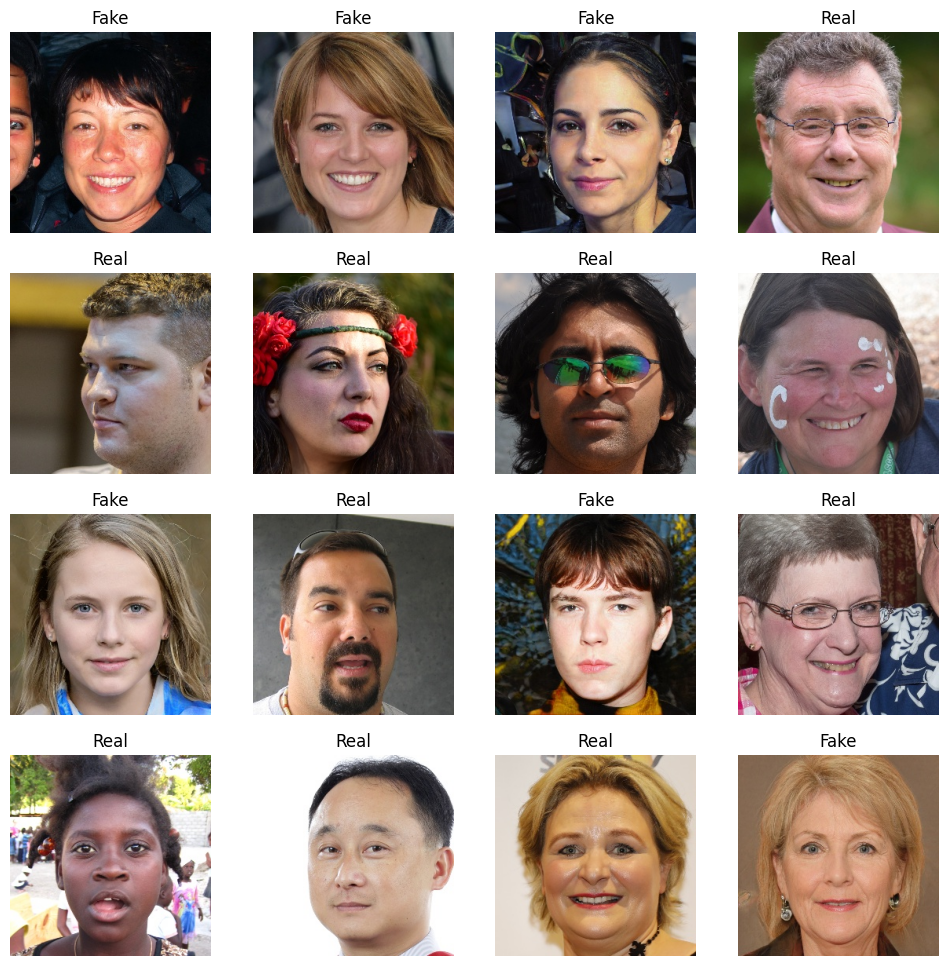

In [ ]:
img,lbl = next(train_ds)
plot_images(img,lbl)


In [ ]:
for img, label in train_ds:
    print("Values: ", img[0])
    print("Label: ", label[0])
    break

Values:  [[[0.7372549  0.7176471  0.7058824 ]
  [0.74509805 0.7254902  0.7137255 ]
  [0.7568628  0.7254902  0.7176471 ]
  ...
  [0.3647059  0.39607847 0.40784317]
  [0.37647063 0.40784317 0.41960788]
  [0.37647063 0.40784317 0.41960788]]

 [[0.72156864 0.7019608  0.6901961 ]
  [0.7254902  0.7058824  0.69411767]
  [0.73333335 0.7019608  0.69411767]
  ...
  [0.39607847 0.427451   0.43921572]
  [0.41176474 0.43921572 0.46274513]
  [0.427451   0.45882356 0.47058827]]

 [[0.7137255  0.69411767 0.6784314 ]
  [0.7176471  0.69803923 0.68235296]
  [0.73333335 0.7019608  0.6901961 ]
  ...
  [0.4431373  0.4784314  0.49803925]
  [0.44705886 0.48235297 0.50980395]
  [0.454902   0.4901961  0.50980395]]

 ...

 [[0.36078432 0.43529415 0.49411768]
  [0.32156864 0.39607847 0.454902  ]
  [0.30980393 0.37647063 0.43921572]
  ...
  [0.40784317 0.34509805 0.21176472]
  [0.37647063 0.3019608  0.1764706 ]
  [0.36862746 0.3019608  0.18431373]]

 [[0.30980393 0.39607847 0.44705886]
  [0.3019608  0.38823533 0.4

In [ ]:
for img, label in train_ds:
    print(img.shape)
    print(label.shape)
    break

(64, 256, 256, 3)
(64,)


In [ ]:
train_ds.class_indices

{'fake': 0, 'real': 1}

# Buliding and traing Models

# VGG16

In [ ]:
import cv2
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
import keras
from keras import layers
from sklearn import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.layers import Dense, Conv2D, MaxPool2D, Input, GlobalAveragePooling2D,MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K

In [ ]:
def limit_data(data_dir,n=100):
    a=[]
    for i in os.listdir(data_dir):
        for k,j in enumerate(os.listdir(data_dir+'/'+i)):
            if k>n:continue
            a.append((f'{data_dir}/{i}/{j}',i))
    return pd.DataFrame(a,columns=['filename','class'])
base_path = '../input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/'
image_gen = ImageDataGenerator(rescale=1./255.)
batch_size = 32
print("Organised")
train_df = limit_data(base_path+'train',50000)
valid_df = limit_data(base_path+'valid',10000)
test_df = limit_data(base_path+'test',10000)
train_flow = image_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical")
valid_flow = image_gen.flow_from_dataframe(
    dataframe=valid_df,
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical")
test_flow = image_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=1,
    shuffle=False,
    class_mode="categorical")

Organised
Found 100000 validated image filenames belonging to 2 classes.
Found 20000 validated image filenames belonging to 2 classes.
Found 20000 validated image filenames belonging to 2 classes.


In [ ]:
def VGG16(input_shape=None):
    img_input = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1')(
        img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1')(
        x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2')(
        x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(
        x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2')(
        x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3')(
        x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1')(
        x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2')(
        x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_3')(
        x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1')(
        x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2')(
        x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_3')(
        x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool5')(x)
    inputs = img_input
    model = Model(inputs, x, name='vggface_vgg16')
    model.load_weights('/content/vgg16_weights.h5', by_name=True)
    return model

In [ ]:
vgg_model = VGG16(input_shape=(224,224,3))
# for layers in vgg_model.layers:
#     layers.trainable=False
last_layer = vgg_model.get_layer('pool5').output
flat_layer = GlobalAveragePooling2D()(last_layer)
fc1 = Dense(1024, activation='relu', name='fc1')(flat_layer)
fc2 = Dense(1024, activation='relu', name='fc2')(fc1)
fc3 = Dense(512, activation='relu', name='fc3')(fc2)
dense2 = Dense(2, activation='sigmoid', name='dense2')(fc3)
model = Model(vgg_model.input, dense2)

In [ ]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0   

In [ ]:
model.compile(
    loss=keras.losses.categorical_crossentropy,
    metrics=['acc'],
    optimizer=tf.keras.optimizers.Adam(0.0001)
)

In [ ]:
train_steps = 100000//2048
valid_steps = 20000//512
# train_steps = len(train_df)//batch_size
# valid_steps = len(valid_df)//batch_size
filepath_model = "model_vggface.h5"
checkpoint = ModelCheckpoint(filepath_model, monitor='val_acc', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2,
                                   verbose=1, mode='max', min_lr=0.00001)
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_flow,
                    steps_per_epoch=train_steps,
                    validation_data=valid_flow,
                    validation_steps=valid_steps,
                    epochs=10,
                    verbose=1,
                   callbacks=callbacks_list)

Epoch 1/10
48/48 [==============================] - ETA: 0s - loss: 0.2582 - acc: 0.8926
Epoch 1: val_acc improved from -inf to 0.86699, saving model to model_vggface.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 26s 546ms/step - loss: 0.2582 - acc: 0.8926 - val_loss: 0.3272 - val_acc: 0.8670 - lr: 1.0000e-04
Epoch 2/10
48/48 [==============================] - ETA: 0s - loss: 0.2306 - acc: 0.9154
Epoch 2: val_acc improved from 0.86699 to 0.89103, saving model to model_vggface.h5
48/48 [==============================] - 31s 651ms/step - loss: 0.2306 - acc: 0.9154 - val_loss: 0.2516 - val_acc: 0.8910 - lr: 1.0000e-04
Epoch 3/10
48/48 [==============================] - ETA: 0s - loss: 0.2266 - acc: 0.9030
Epoch 3: val_acc improved from 0.89103 to 0.92147, saving model to model_vggface.h5
48/48 [==============================] - 31s 646ms/step - loss: 0.2266 - acc: 0.9030 - val_loss: 0.2072 - val_acc: 0.9215 - lr: 1.0000e-04
Epoch 4/10
48/48 [==============================] - ETA: 0s - loss: 0.2065 - acc: 0.9284
Epoch 4: val_acc improved from 0.92147 to 0.93590, saving model to model_vggface.h5
48/48 [==============================] - 26s 541ms/step - loss: 

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

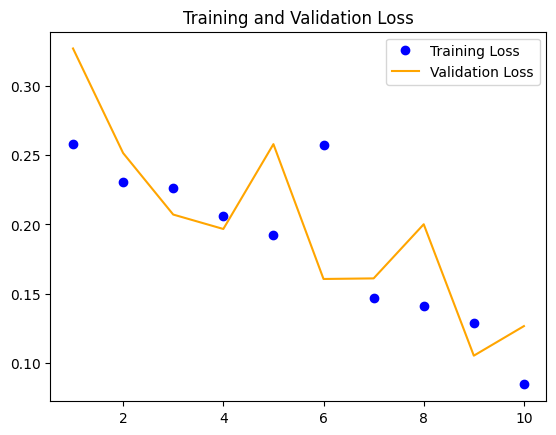

In [ ]:
import matplotlib.pyplot as plt
plot_loss(range(1, len(loss) + 1), loss, val_loss)

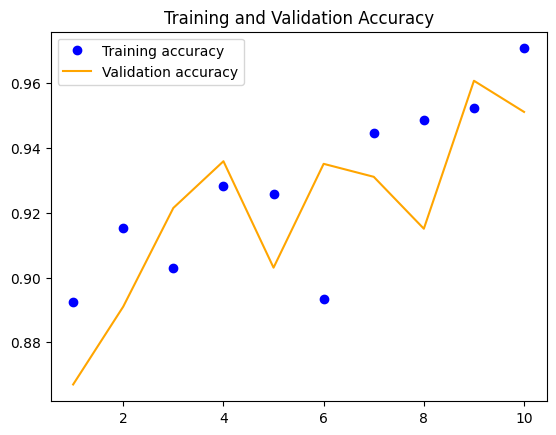

In [ ]:
plot_accuracy(range(1, len(loss) + 1), acc, val_acc)

# Densenet121

In [ ]:

from tensorflow.keras.models import Model, Sequential
def dense_block(x, blocks, name):
    for i in range(blocks):
        x = conv_block(x, 32, name=name + '_block' + str(i + 1))
    return x
def transition_block(x, reduction, name):
    bn_axis = 3 if K.image_data_format() == 'channels_last' else 1
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_bn')(x)
    x = layers.Activation('relu', name=name + '_relu')(x)
    x = layers.Conv2D(int(K.int_shape(x)[bn_axis] * reduction),
                      1,
                      use_bias=False,
                      name=name + '_conv')(x)
    x = layers.AveragePooling2D(2, strides=2, name=name + '_pool')(x)
    return x
def conv_block(x, growth_rate, name):
    bn_axis = 3 if K.image_data_format() == 'channels_last' else 1
    x1 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_0_bn')(x)
    x1 = layers.Activation('relu', name=name + '_0_relu')(x1)
    x1 = layers.Conv2D(4 * growth_rate, 1, use_bias=False, name=name + '_1_conv')(x1)
    x1 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_1_bn')(x1)
    x1 = layers.Activation('relu', name=name + '_1_relu')(x1)
    x1 = layers.Conv2D(growth_rate, 3, padding='same', use_bias=False, name=name + '_2_conv')(x1)
    x = layers.Concatenate(axis=bn_axis, name=name + '_concat')([x, x1])
    return x
blocks=[6,12,24,16]
img_input=Input(shape=(224,224,3))
bn_axis = 3 if K.image_data_format() == 'channels_last' else 1
x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)))(img_input)
x = layers.Conv2D(64, 7, strides=2, use_bias=False, name='conv1/conv')(x)
x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='conv1/bn')(x)
x = layers.Activation('relu', name='conv1/relu')(x)
x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)))(x)
x = layers.MaxPooling2D(3, strides=2, name='pool1')(x)
x = dense_block(x, blocks[0], name='conv2')
x = transition_block(x, 0.5, name='pool2')
x = dense_block(x, blocks[1], name='conv3')
x = transition_block(x, 0.5, name='pool3')
x = dense_block(x, blocks[2], name='conv4')
x = transition_block(x, 0.5, name='pool4')
x = dense_block(x, blocks[3], name='conv5')
x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='bn')(x)
x = layers.Activation('relu', name='relu')(x)
model=Model(img_input,x)
model=Sequential([
    model,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_8 (Functional)        (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_6  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 7038529 (26.85 MB)
Trainable params: 6954881 (26.53 MB)
Non-trainable params: 83648 (326.75 KB)
_________________________________________________________________


In [ ]:
model.compile(
    loss=keras.losses.binary_crossentropy,
    metrics=['acc'],
    optimizer=tf.keras.optimizers.Adam(0.0001)
)

In [ ]:
train_steps = 100000//2048
valid_steps = 20000//512
# train_steps = len(train_df)//batch_size
# valid_steps = len(valid_df)//batch_size
filepath_model = "model_densenet121.h5"
checkpoint = ModelCheckpoint(filepath_model, monitor='val_acc', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2,
                                   verbose=1, mode='max', min_lr=0.00001)
callbacks_list = [checkpoint, reduce_lr]

history1 = model.fit(train_flow,
                    steps_per_epoch=train_steps,
                    validation_data=valid_flow,
                    validation_steps=valid_steps,
                    epochs=20,
                    verbose=1,
                    callbacks=callbacks_list)

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 0.4934 - acc: 0.7598
Epoch 1: val_acc improved from -inf to 0.50561, saving model to model_densenet121.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 26s 531ms/step - loss: 0.4934 - acc: 0.7598 - val_loss: 1.1590 - val_acc: 0.5056 - lr: 1.0000e-04
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 0.4877 - acc: 0.7741
Epoch 2: val_acc improved from 0.50561 to 0.62099, saving model to model_densenet121.h5
48/48 [==============================] - 25s 521ms/step - loss: 0.4877 - acc: 0.7741 - val_loss: 0.6942 - val_acc: 0.6210 - lr: 1.0000e-04
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 0.4711 - acc: 0.7832
Epoch 3: val_acc did not improve from 0.62099
48/48 [==============================] - 22s 463ms/step - loss: 0.4711 - acc: 0.7832 - val_loss: 0.8911 - val_acc: 0.5433 - lr: 1.0000e-04
Epoch 4/20
48/48 [==============================] - ETA: 0s - loss: 0.4681 - acc: 0.7754
Epoch 4: val_acc did not improve from 0.62099

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
48/48 [==============================] - 28s 580ms/step - l

In [ ]:
model.save('densenet121.h5')

In [ ]:
"""
Plot the training and validation loss and accuracy
epochs - list of epoch numbers
loss - training loss for each epoch
val_loss - validation loss for each epoch
"""
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [ ]:
acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

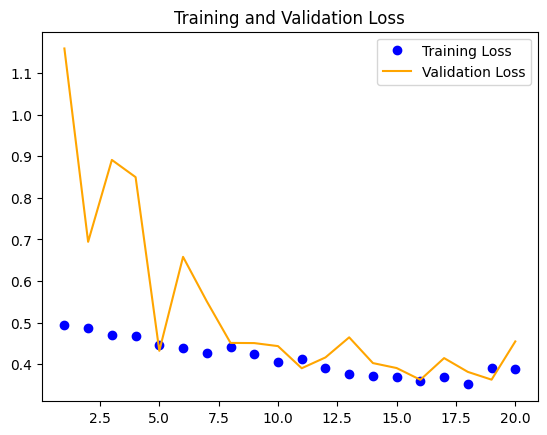

In [ ]:
plot_loss(range(1, len(loss) + 1), loss, val_loss)

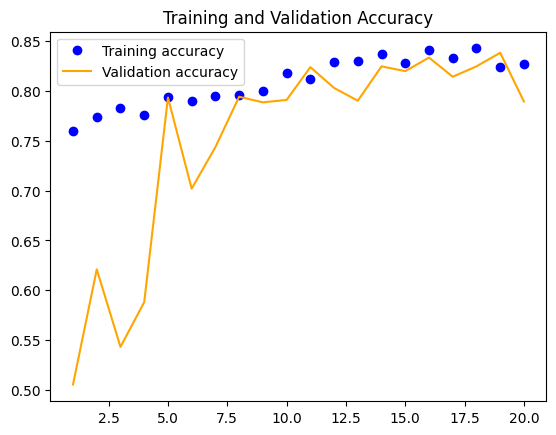

In [ ]:
plot_accuracy(range(1, len(loss) + 1), acc, val_acc)

# Hybrid [Resnet50/dense121]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import concatenate, Dense, Input
from keras.applications.densenet import DenseNet121
from keras.applications.resnet import ResNet50
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report


In [ ]:
def create_hybrid_model(input_shape, num_classes):
    # Load DenseNet121 and ResNet50 base models
    densenet = DenseNet121(include_top=False, input_shape=input_shape, pooling='avg')
    resnet = ResNet50(include_top=False, input_shape=input_shape, pooling='avg')

    # Make sure the base models are not trainable to retain their learned features
    for layer in densenet.layers:
        layer.trainable = False
    for layer in resnet.layers:
        layer.trainable = False

    # Concatenate the outputs of the two models
    combined_output = concatenate([densenet.output, resnet.output])

    # Add a fully connected layer and the final classification layer
    x = Dense(256, activation='relu')(combined_output)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=[densenet.input, resnet.input], outputs=predictions)

    return model


In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_8 (Functional)        (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_6  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 7038529 (26.85 MB)
Trainable params: 6954881 (26.53 MB)
Non-trainable params: 83648 (326.75 KB)
_________________________________________________________________


In [ ]:
model.compile(
    loss=keras.losses.binary_crossentropy,
    metrics=['acc'],
    optimizer=tf.keras.optimizers.Adam(0.0001)
)

In [ ]:
train_steps = 100000//2048
valid_steps = 20000//512
filepath_model = "model_HYBRID.h5"
checkpoint = ModelCheckpoint(filepath_model, monitor='val_acc', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2,
                                   verbose=1, mode='max', min_lr=0.00001)
callbacks_list = [checkpoint, reduce_lr]

history3 = model.fit(train_flow,
                    steps_per_epoch=train_steps,
                    validation_data=valid_flow,
                    validation_steps=valid_steps,
                    epochs=20,
                    verbose=1,
                    callbacks=callbacks_list)

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 0.4027 - acc: 0.8118
Epoch 1: val_acc improved from -inf to 0.74279, saving model to model_HYBRID.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 98s 525ms/step - loss: 0.4027 - acc: 0.8118 - val_loss: 0.5856 - val_acc: 0.7428 - lr: 1.0000e-04
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 0.4124 - acc: 0.8125
Epoch 2: val_acc did not improve from 0.74279
48/48 [==============================] - 25s 522ms/step - loss: 0.4124 - acc: 0.8125 - val_loss: 0.6929 - val_acc: 0.6018 - lr: 1.0000e-04
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 0.4233 - acc: 0.7995
Epoch 3: val_acc did not improve from 0.74279

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
48/48 [==============================] - 22s 460ms/step - loss: 0.4233 - acc: 0.7995 - val_loss: 0.6282 - val_acc: 0.6763 - lr: 1.0000e-04
Epoch 4/20
48/48 [==============================] - ETA: 0s - loss: 0.4030 - acc: 0.8079
Epoch 4: val_acc improved from 0.74279 to 0.81090, saving model to model_HYBRID.h5
48/48 [==============================] - 23s 472ms/step - loss: 

In [ ]:
acc = history3.history['acc']
val_acc = history3.history['val_acc']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

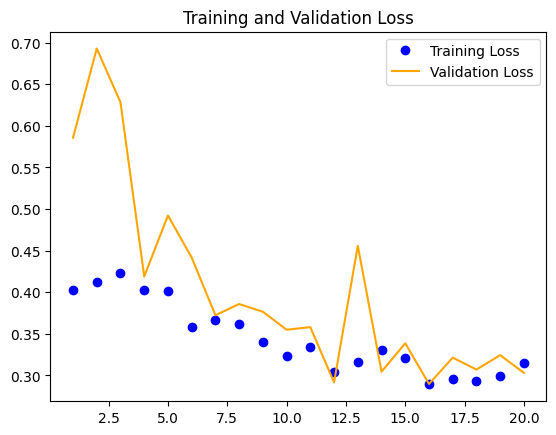

In [ ]:
plot_loss(range(1, len(loss) + 1), loss, val_loss)

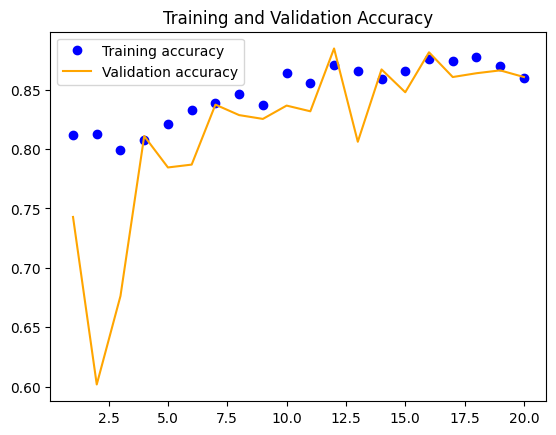

In [ ]:
plot_accuracy(range(1, len(loss) + 1), acc, val_acc)

# Comaprison of All models

In [ ]:
def extract_metrics(history):
    metrics = {}
    try:
        metrics['acc'] = history.history['acc']  # Adjust if the key is 'accuracy'
        metrics['val_acc'] = history.history['val_acc']  # Adjust if the key is 'val_accuracy'
        metrics['loss'] = history.history['loss']
        metrics['val_loss'] = history.history['val_loss']
    except KeyError as e:
        print(f"KeyError: {e}. Please check the available keys in the history object: {list(history.history.keys())}")
    return metrics


In [ ]:
densenet_metrics = extract_metrics(history1)
hybrid_metrics = extract_metrics(history3)
vgg16_metrics = extract_metrics(history)


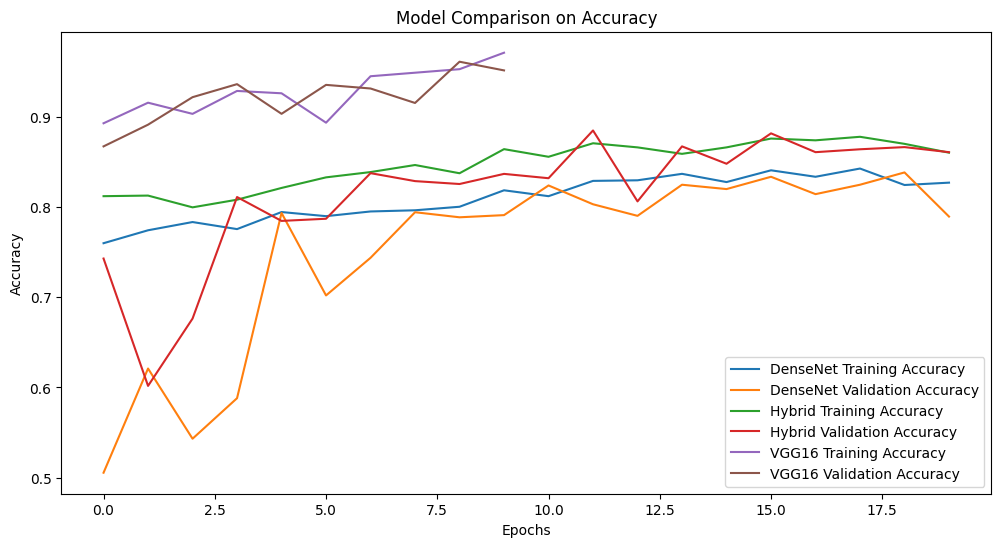

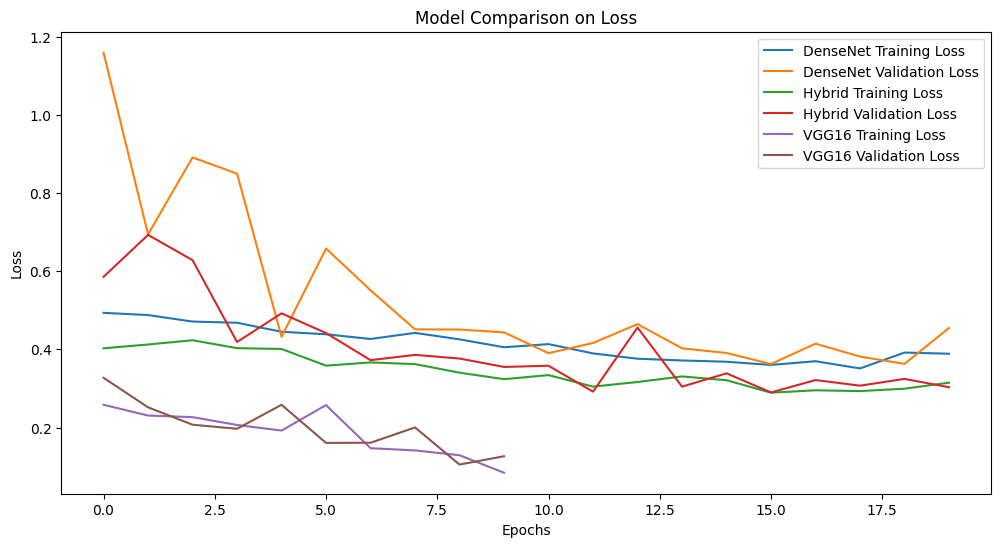

In [ ]:
def plot_extracted_metrics(metrics, labels):
    plt.figure(figsize=(12, 6))

    for met, label in zip(metrics, labels):
        plt.plot(met['acc'], label=f'{label} Training Accuracy')
        plt.plot(met['val_acc'], label=f'{label} Validation Accuracy')

    plt.title('Model Comparison on Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    for met, label in zip(metrics, labels):
        plt.plot(met['loss'], label=f'{label} Training Loss')
        plt.plot(met['val_loss'], label=f'{label} Validation Loss')

    plt.title('Model Comparison on Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Assuming the metrics extraction was successful
plot_extracted_metrics([densenet_metrics, hybrid_metrics, vgg16_metrics], ['DenseNet', 'Hybrid', 'VGG16'])


# Prediction

1/1 [==============================] - 4s 4s/step


Text(0.5, 1.0, 'This image is 0.00% Fake and 100.00% Real.')

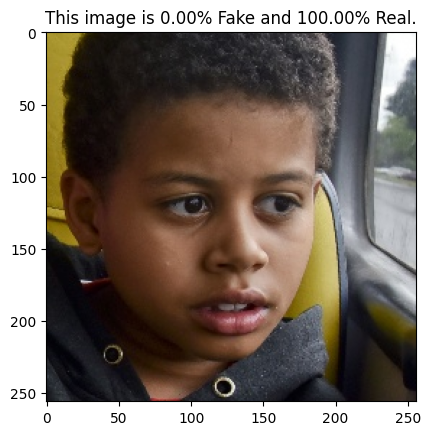

In [ ]:
#real example
test_image = tf.keras.preprocessing.image.load_img('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/00343.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)


test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")


1/1 [==============================] - 0s 31ms/step


Text(0.5, 1.0, 'This image is 0.01% Fake and 99.99% Real.')

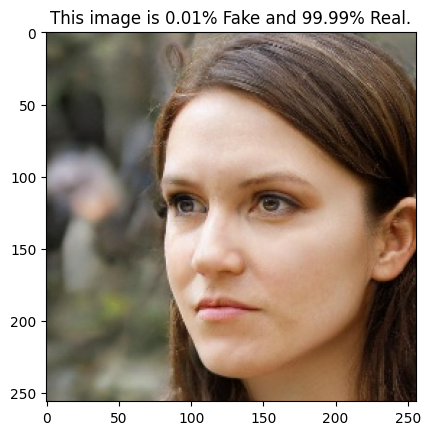

In [ ]:
test_image = tf.keras.preprocessing.image.load_img('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/00V5CZZSSO.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)

#fake example
test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")